In [20]:
# load data
data = np.load('dataset_splits3.npz', allow_pickle=True)
X_train, y_train =  texts_train, labels_train
X_val, y_val = texts_val, labels_val
X_test, y_test = texts_test, labels_test

In [21]:
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable
from keras.saving import register_keras_serializable
import tensorflow as tf

In [22]:
def compute_class_weights(labels):
    class_weights = np.sum(labels, axis=0) / float(len(labels))
    max_weight = np.max(class_weights)
    return max_weight / class_weights

# Compute the class weights
class_weights = compute_class_weights(labels_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Calculated Class Weights: {class_weights_dict}")

def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        weights = y_true * class_weights + (1 - y_true)
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(bce * weights)
    return loss

Calculated Class Weights: {0: np.float64(1.0), 1: np.float64(21.426235112398476), 2: np.float64(5.8609650362053705), 3: np.float64(14.430381899970007), 4: np.float64(1.1795194237116449), 5: np.float64(5.5552130911887225), 6: np.float64(16.016855676405747)}


In [23]:
# load model
model = tf.keras.models.load_model("last_model.keras", compile=False)


In [24]:
model.compile(
    optimizer='adam',
    loss=weighted_binary_crossentropy(class_weights),
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

In [33]:
# load vocabulary
with open('vectorizer_vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Vectorizer setup from vocabulary
MAX_WORDS = 40000  
SEQUENCE_LENGTH = 600  

vectorizer = TextVectorization(
    max_tokens=MAX_WORDS,
    output_sequence_length=SEQUENCE_LENGTH,
    output_mode='int'
)

vectorizer.set_vocabulary(vocabulary)

In [34]:
# Helper function
def create_dataset(texts, labels):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    ds = ds.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().shuffle(20000).batch(64).prefetch(tf.data.AUTOTUNE)
    return ds

# Apply to the three groups
train = create_dataset(texts_train, labels_train)
val = create_dataset(texts_val, labels_val)
test = create_dataset(texts_test, labels_test)

In [35]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Performance measure for each classification
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in val:
    X_true, y_true = batch

    # Making predictions as tensors
    yhat = model(X_true, training=False)

    # Convert values ​​to binary
    y_true_binary = tf.cast(y_true >= 0.5, tf.float32)
    yhat_binary = tf.cast(yhat >= 0.5, tf.float32)

    # Update metrics
    pre.update_state(y_true_binary, yhat_binary)
    re.update_state(y_true_binary, yhat_binary)
    acc.update_state(y_true_binary, yhat_binary)


print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8969367146492004, Recall: 0.7150833010673523, Accuracy: 0.9499744772911072


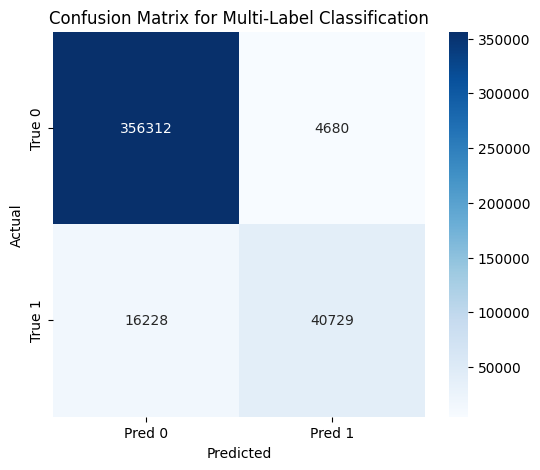

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten y_true and yhat to numpy for multi-label
y_true_np = []
y_pred_np = []

for batch in val:
    X_true, y_true = batch
    yhat = model(X_true, training=False)
    
    # Flatten the multi-label true and predicted values
    y_true_np.extend(tf.cast(y_true >= 0.5, tf.int32).numpy().flatten())
    y_pred_np.extend(tf.cast(yhat >= 0.5, tf.int32).numpy().flatten())

# Calculate confusion matrix for each label (binary)
cm = confusion_matrix(y_true_np, y_pred_np)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Multi-Label Classification')
plt.show()


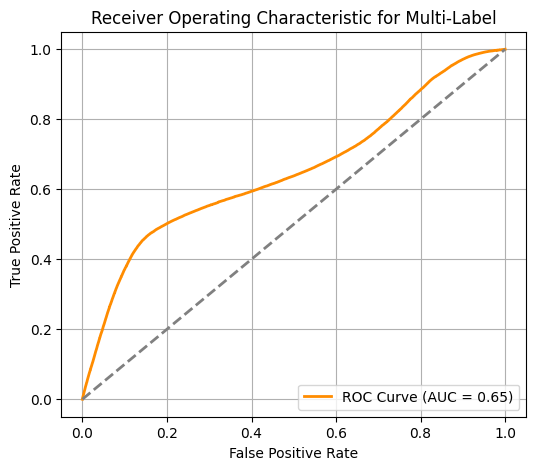

In [38]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = []
for batch in val:
    X_true, _ = batch
    yhat = model(X_true, training=False)
    y_pred_probs.extend(yhat.numpy().flatten())

fpr, tpr, _ = roc_curve(y_true_np, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Draw an ROC curve for each category.
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Label')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

label_names = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

y_true_all = []
y_pred_all = []

for batch in val:
    X_true, y_true = batch
    yhat = model(X_true, training=False)

    y_true_all.append(tf.cast(y_true >= 0.5, tf.int32).numpy())
    y_pred_all.append(tf.cast(yhat >= 0.5, tf.int32).numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

# Calculate the metrics for each category
precisions = precision_score(y_true_all, y_pred_all, average=None, zero_division=0)
recalls = recall_score(y_true_all, y_pred_all, average=None, zero_division=0)
f1s = f1_score(y_true_all, y_pred_all, average=None, zero_division=0)

df_metrics = pd.DataFrame({
    'Label': label_names,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1s
})

print(df_metrics)


             Label  Precision    Recall  F1-Score
0         toxicity   0.959595  0.755453  0.845375
1  severe_toxicity   0.000000  0.000000  0.000000
2          obscene   0.681127  0.615267  0.646524
3           threat   0.645963  0.465845  0.541314
4           insult   0.892743  0.701971  0.785946
5  identity_attack   0.653461  0.565775  0.606465
6  sexual_explicit   0.617930  0.630033  0.623922


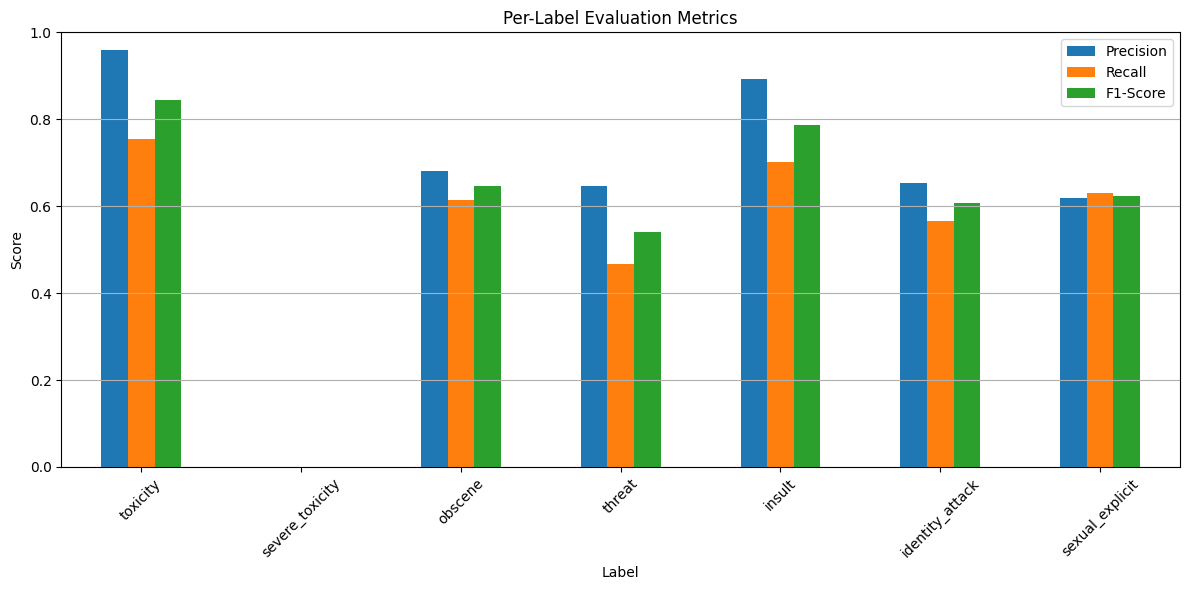

In [41]:
# Chart of the three measures for each category
df_metrics.set_index('Label').plot(kind='bar', figsize=(12, 6))
plt.title("Per-Label Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()